In [94]:
import xarray as xr
from glob import glob
import sys
import pandas as pd
import otps
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import scipy
from scipy import ndimage as nd
import matplotlib.pyplot as plt


def interp_tides(x_coords, y_coords, z_coords, resolution=500, sigma=20):
    
    # Extract xy and elev points
    points_xy = np.vstack([y_coords, x_coords]).T
    values_elev = z_coords

    # Create grid to interpolate into
    x_size, upleft_x, y_size, upleft_y = resolution, x_coords.min(), resolution, y_coords.max()
    bottomright_x = x_coords.max() 
    bottomright_y = y_coords.min()    
    grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * y_size, upleft_x:bottomright_x:1j * x_size]

    # Interpolate x, y and z values using linear/TIN interpolation
    out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

    # Calculate nearest
    nearest_inds = nd.distance_transform_edt(input=np.isnan(out), return_distances=False, return_indices=True)
    out = out[tuple(nearest_inds)]

    # Apply guassian filter
    out = nd.filters.gaussian_filter(out, sigma=sigma)
    return out[:,:,0]

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling

In [3]:
files = glob('Cambridge_Gulf/*.nc')

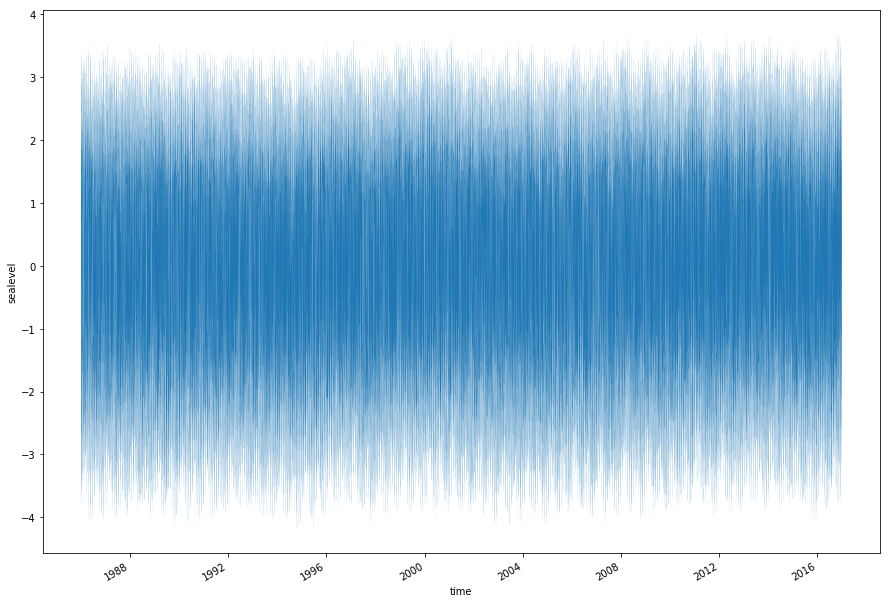

In [241]:
sealevel_ds = xr.open_dataset(files[-52])
sealevel_ds = sealevel_ds.sel(time=slice('1986-01-01', '2018-01-01'))
sealevel_ds['sealevel'] = sealevel_ds['sealevel'] / 1000.0
sealevel_ds.sealevel.plot(linewidth=0.05, size=10)

# sample_point = sealevel_ds.sel(time=pd.datetime(2006, 12, 1, 5, 22), method='nearest')
sample_period = sealevel_ds
lon = sample_period.longitude.item()
lat = sample_period.latitude.item()

Loading ls5 pixel quality
    Loading 342 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 67 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 81 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


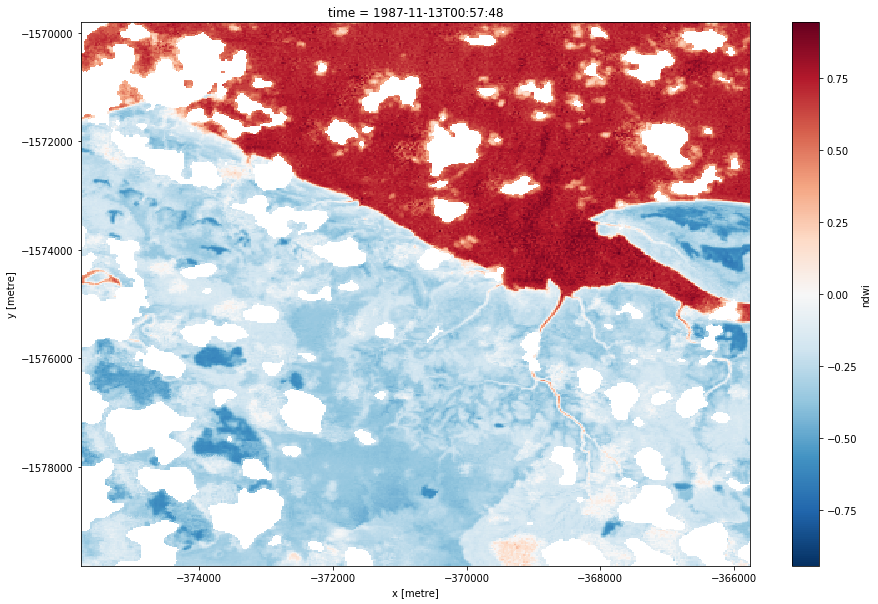

In [250]:
import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Set up analysis data query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 5000, x + 5000),
         'y': (y - 5000, y + 5000),         
         'crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'output_crs': 'EPSG:3577',
         'time': ('1986-01-01', '2016-12-31')}

# Load in only clear Landsat observations with < 1% unclear values
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'], 
                                       masked_prop=0.0, mask_pixel_quality=True) 

# data['ndwi'] = (data.green - data.nir) / (data.green + data.nir)
data['ndwi'] = (data.green - data.swir1) / (data.green + data.swir1)
data.ndwi.isel(time = 5).plot(size=10)

## Load WA sea level into xarray format

In [6]:
# Open all data
all_nodes = xr.open_mfdataset(paths=files, concat_dim='file').squeeze('coast_id')

# Interpolate hourly results to get sea level estimates for exact acquisition time
all_nodes = all_nodes.interp(time=data.time.data.astype('M8[s]').astype('O').tolist())

# Select only required timesteps
all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

# Re-index to give latitude, longitude and time dimensions
test = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()


In [156]:
for i in range(0,len(test.time)-1):
    
    # Import as a dataframe with lon, lat, time, sea level columns
    test_df_subset = test.isel(time=i).sealevel.to_dataframe().dropna(axis=0).reset_index() 

    from pyproj import Proj, transform
    xx, yy = transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), test_df_subset.longitude.values, test_df_subset.latitude.values)
    test_df_subset['Coordinates'] = list(zip(*transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), test_df_subset.longitude.values, test_df_subset.latitude.values)))

    # # Create geopandas dataframe by creating geometry column
    # test_df_subset['Coordinates'] = list(zip(test_df_subset.longitude, test_df_subset.latitude))
    test_df_subset['Coordinates'] = test_df_subset['Coordinates'].apply(Point)
    test_df_subset = gpd.GeoDataFrame(test_df_subset, geometry='Coordinates', crs='EPSG:3577')
    # # # test_gdf.to_file('test.shp')

    # Interpolate
    resolution = 500
    out = interp_tides(x_coords=test_df_subset['longitude'].values, 
                       y_coords=test_df_subset['latitude'].values, 
                       z_coords=test_df_subset[['sealevel']].values, 
                       sigma=15, resolution=resolution)


    # Create land sea mask from shapefile
    test_affine = rasterio.transform.from_bounds(west=xx.min(), 
                                                 south=yy.min(), 
                                                 east=xx.max(), 
                                                 north=yy.max(), width=out.shape[1], height=out.shape[0])

    coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
                                                     out_shape=(resolution, resolution),
                                                     transform=test_affine,
                                                     all_touched=False, invert=True)
    
    print(np.min(out), np.max(out))

    # Remove land
    out[coastline_mask] = np.nan
    out[out > 2500] = np.nan
    out[out < 1500] = np.nan

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 16))
    test_df_subset.plot(column='sealevel', ax=ax[0])
    im = ax[1].imshow(out, extent=[upleft_x, bottomright_x, bottomright_y, upleft_y], vmin=-2000, vmax=3000)
    # fig.colorbar(im)



time  sealevel
latitude   longitude                               
-15.157413 128.119768 2017-02-16 01:29:42       NaN
           128.120130 2017-02-16 01:29:42       NaN
           128.120234 2017-02-16 01:29:42       NaN
           128.120701 2017-02-16 01:29:42       NaN
           128.121014 2017-02-16 01:29:42       NaN
           128.122523 2017-02-16 01:29:42       NaN
           128.123576 2017-02-16 01:29:42       NaN
           128.123766 2017-02-16 01:29:42       NaN
           128.123813 2017-02-16 01:29:42       NaN
           128.123830 2017-02-16 01:29:42       NaN
           128.124089 2017-02-16 01:29:42       NaN
           128.125293 2017-02-16 01:29:42       NaN
           128.125574 2017-02-16 01:29:42       NaN
           128.125737 2017-02-16 01:29:42       NaN
           128.125821 2017-02-16 01:29:42       NaN
           128.126000 2017-02-16 01:29:42       NaN
           128.126367 2017-02-16 01:29:42       NaN
           128.128883 2017-02-16 01:29:42       NaN
           128.128916 2017-02-16 01:29:42       NaN
           128.129479 2017-02-16 01:29:42       NaN
           128.130492 2017-02-16 01:29:42       NaN
           128.132230 2017-02-16 01:29:42       NaN
           128.132974 2017-02-16 01:29:42       NaN
           128.133793 2017-02-16 01:29:42       NaN
           128.135974 2017-02-16 01:29:42       NaN
           128.139521 2017-02-16 01:29:42       NaN
           128.140234 2017-02-16 01:29:42       NaN
           128.143915 2017-02-16 01:29:42       NaN
           128.150365 2017-02-16 01:29:42       NaN
           128.150473 2017-02-16 01:29:42       NaN
...                                   ...       ...
-14.696671 128.522657 2017-02-16 01:29:42       NaN
           128.535513 2017-02-16 01:29:42       NaN
           128.535521 2017-02-16 01:29:42       NaN
           128.551589 2017-02-16 01:29:42       NaN
           128.554093 2017-02-16 01:29:42       NaN
           128.564926 2017-02-16 01:29:42       NaN
           128.577188 2017-02-16 01:29:42       NaN
           128.582114 2017-02-16 01:29:42       NaN
           128.587526 2017-02-16 01:29:42       NaN
           128.592445 2017-02-16 01:29:42       NaN
           128.599826 2017-02-16 01:29:42       NaN
           128.610780 2017-02-16 01:29:42       NaN
           128.613023 2017-02-16 01:29:42       NaN
           128.614532 2017-02-16 01:29:42       NaN
           128.620525 2017-02-16 01:29:42       NaN
           128.623451 2017-02-16 01:29:42       NaN
           128.624361 2017-02-16 01:29:42       NaN
           128.630717 2017-02-16 01:29:42       NaN
           128.633765 2017-02-16 01:29:42       NaN
           128.637155 2017-02-16 01:29:42       NaN
           128.647742 2017-02-16 01:29:42       NaN
           128.665473 2017-02-16 01:29:42       NaN
           128.683137 2017-02-16 01:29:42       NaN
           128.696693 2017-02-16 01:29:42       NaN
           128.711980 2017-02-16 01:29:42       NaN
           128.720630 2017-02-16 01:29:42       NaN
           128.725704 2017-02-16 01:29:42       NaN
           128.736900 2017-02-16 01:29:42       NaN
           128.741249 2017-02-16 01:29:42       NaN
           128.754304 2017-02-16 01:29:42       NaN

[54756 rows x 2 columns]

## Test ITEM confidence for WA vs OTPS

In [251]:
# Calculate old tide heights
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()
observed_timepoints = [otps.TimePoint(lon, lat, dt) for dt in observed_datetimes]
observed_predictedtides = otps.predict_tide(observed_timepoints)
tideheights_old = [predictedtide.tide_m for predictedtide in observed_predictedtides]
data['tideheights_old'] = xr.DataArray(tideheights_old, [('time', data.time)])

# Calculate new tide heights
# tideheights_new = sealevel_ds.sel(time=observed_datetimes, method='nearest').sealevel.values.tolist()
tideheights_new = sealevel_ds.interp(time=observed_datetimes).sealevel.values.tolist()
data['tideheights_new'] = xr.DataArray(tideheights_new, [('time', data.time)])


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  if __name__ == '__main__':


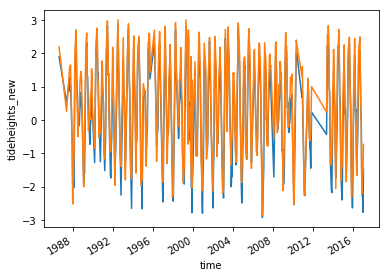

In [252]:
combined_heights = xr.concat([data['tideheights_old'], data['tideheights_new']])
combined_min, combined_max = combined_heights.min(), combined_heights.max()
combined_range = combined_max - combined_min

data['tideheights_old'].plot()
data['tideheights_new'].plot()


-2.924 -2.2653833333850097
6
-2.2653833333850097 -1.6067666667700193
37
-1.6067666667700193 -0.9481500001550289
40
-0.9481500001550289 -0.28953333354003874
61
-0.28953333354003874 0.36908333307495145
70
0.36908333307495145 1.027699999689942
45
1.027699999689942 1.6863166663049323
78
1.6863166663049323 2.3449333329199225
67
2.3449333329199225 3.003549999534912
22
Skip


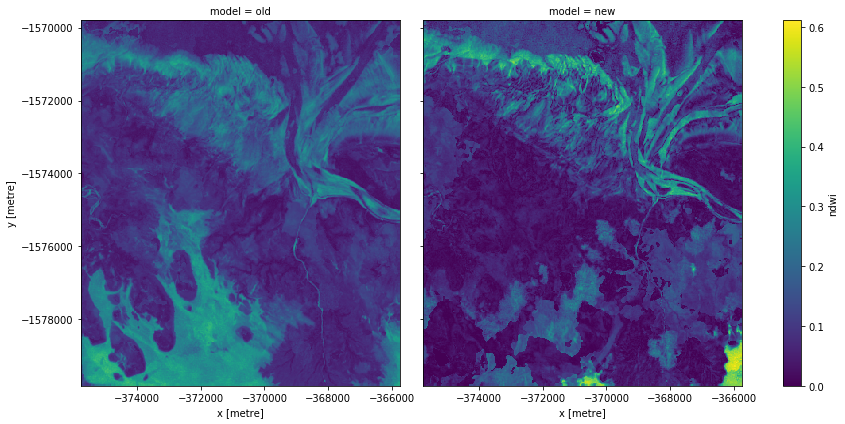

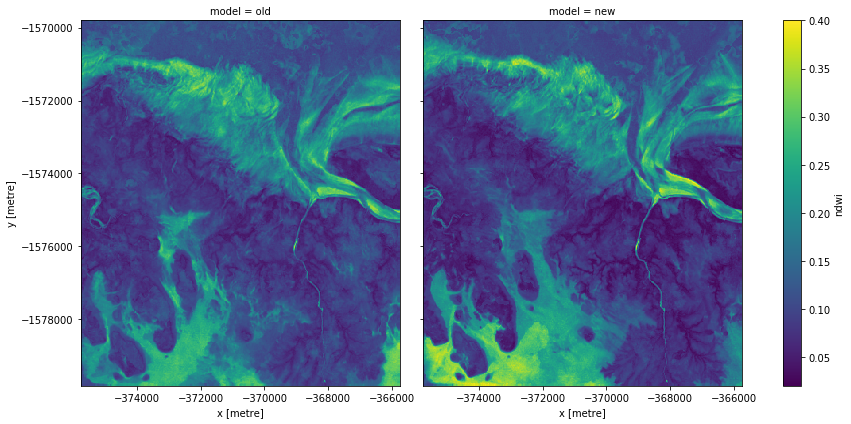

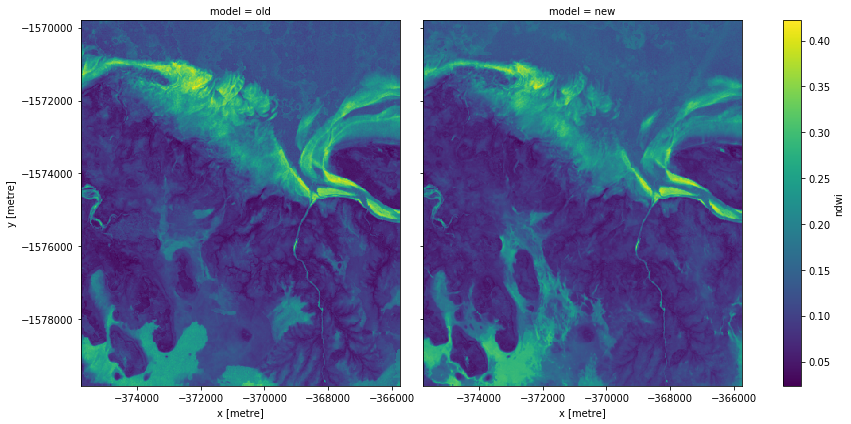

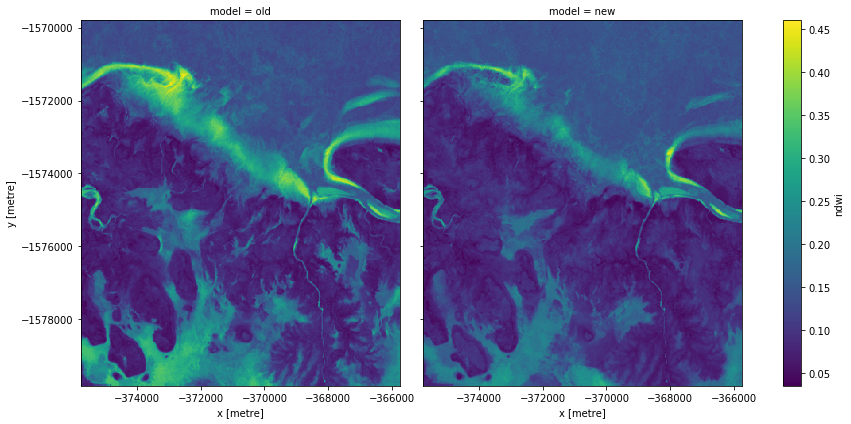

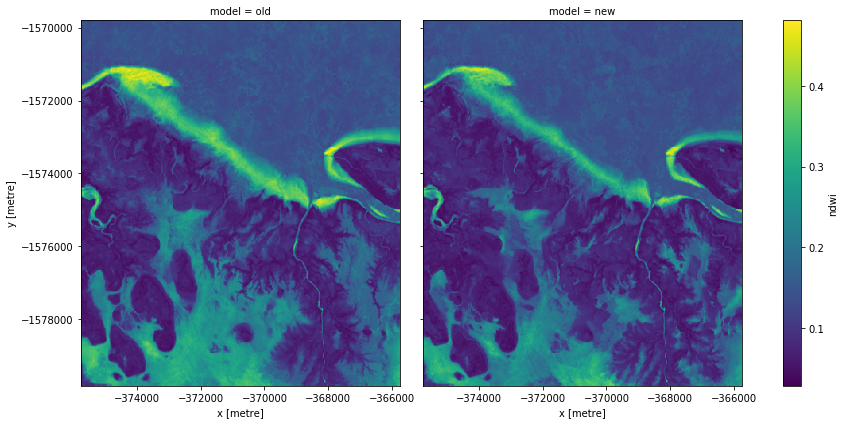

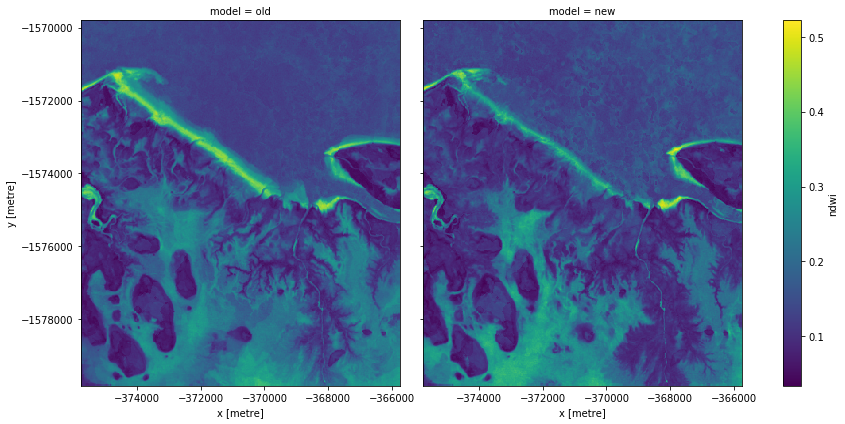

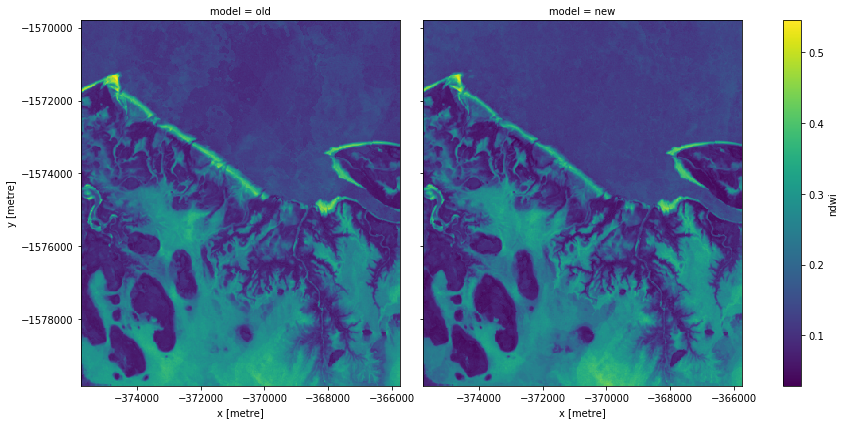

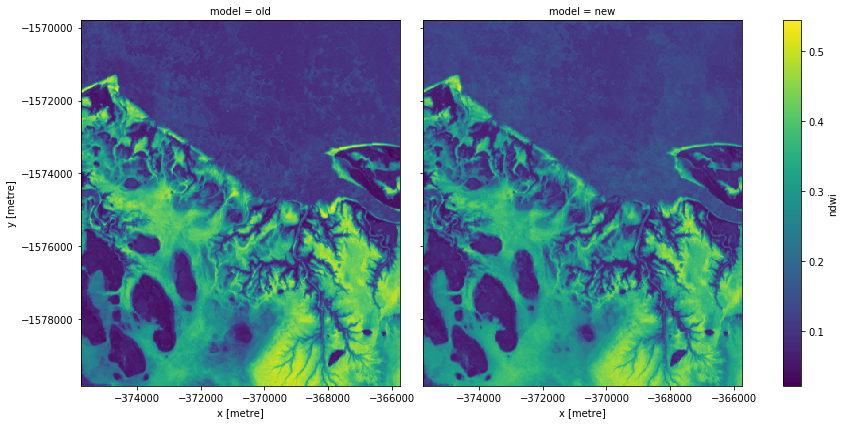

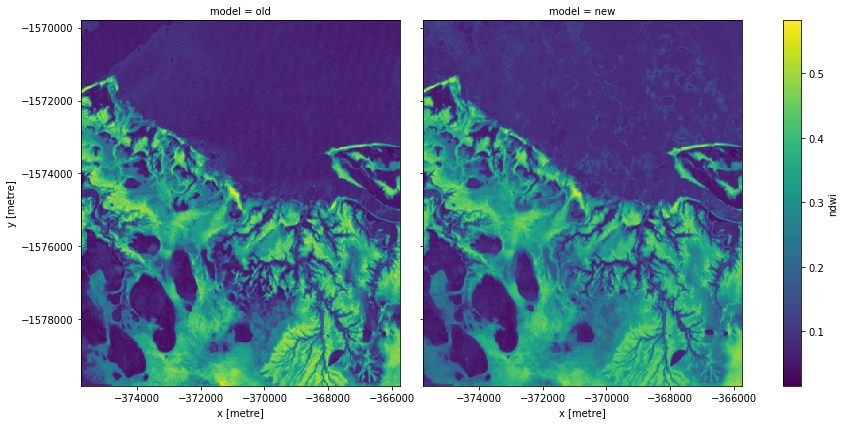

In [253]:
import numpy as np

out = []

for i, min_tide in enumerate(np.linspace(combined_min, combined_max, 10)):
    
    try:
    
        max_tide = np.linspace(combined_min, combined_max, 10)[i+1] 
        print(min_tide, max_tide)

        old_subset = data.where((data.tideheights_old >= min_tide) & (data.tideheights_old <= max_tide), drop = True)
        new_subset = data.where((data.tideheights_new >= min_tide) & (data.tideheights_new <= max_tide), drop = True)

        min_count = min(len(old_subset.time), len(new_subset.time))
        print(min_count)

        if min_count > 1:

            model_comparison = xr.concat([old_subset.ndwi.std(dim = 'time'),
                                          new_subset.ndwi.std(dim = 'time')], 
                                          dim=xr.DataArray(['old', 'new'], dims='model', name='model'))   #.diff(dim='type').plot(size=15)
            model_comparison.plot(col='model', size=6, aspect=1)
            out.append(model_comparison)
            
    except:
        print('Skip')
   


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  if __name__ == '__main__':


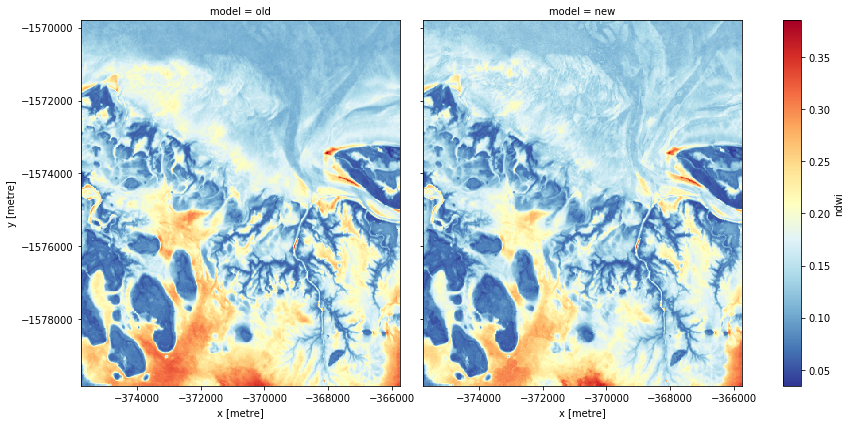

In [254]:
xr.concat(out).mean(dim='concat_dims').plot(col='model', size=6, aspect=1, cmap='RdYlBu_r')

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  if __name__ == '__main__':


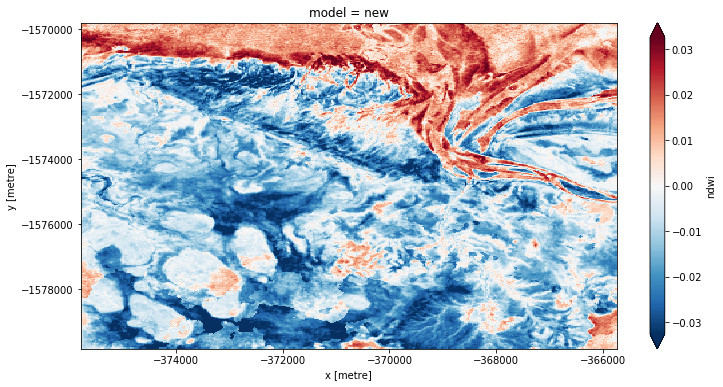

In [255]:
xr.concat(out).mean(dim='concat_dims').diff(dim='model').plot(size=6, aspect=2, robust=True)

In [ ]:
import rasterstats

In [ ]:
test_df

In [ ]:
len(np.unique(test_df.index))